In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from IPython.display import display


# Step 1: Load the dataset

In [79]:

def load_data(file_path):
    """Load the FIFA players dataset from a CSV file."""
    try:
        data = pd.read_csv(file_path)
        display("Dataset successfully loaded!")
        return data
    except FileNotFoundError:
        display(f"File not found: {file_path}")
        return None


# Step 2: Initial data analysis

In [80]:
def initial_analysis(data):
    """Perform initial analysis of the dataset."""
    display("\n--- Dataset Overview ---")
    display(data.head())

    display("\n--- Basic Info ---")
    display(data.info())

    display("\n--- Summary Statistics ---")
    display(data.describe(include='all'))

    display("\n--- Checking for Missing Values ---")
    display(data.isnull().sum())



# Step 3: Data Cleaning

In [81]:

def clean_data(data):
    """Clean the dataset by handling missing values and duplicate rows."""
    display("\n--- Dropping Duplicate Rows ---")
    before_duplicates = len(data)
    data = data.drop_duplicates()
    after_duplicates = len(data)
    display(f"Removed {before_duplicates - after_duplicates} duplicate rows.")

    display("\n--- Handling Missing Values ---")
    missing_threshold = 0.3
    missing_percentage = data.isnull().mean()
    columns_to_drop = missing_percentage[missing_percentage > missing_threshold].index
    display(f"Dropping columns with more than {missing_threshold*100}% missing values: {list(columns_to_drop)}")
    data = data.drop(columns=columns_to_drop)

    for col in data.select_dtypes(include=['float64', 'int64']).columns:
        if data[col].isnull().sum() > 0:
            display(f"Filling missing values in {col} with median.")
            data[col] = data[col].fillna(data[col].median())

    for col in data.select_dtypes(include=['object']).columns:
        if data[col].isnull().sum() > 0:
            display(f"Filling missing values in {col} with 'Unknown'.")
            data[col] = data[col].fillna('Unknown')

    display("\n--- Missing Values After Cleaning ---")
    display(data.isnull().sum())

    return data

def save_cleaned_data(data, output_path):
    """Save the cleaned dataset to a CSV file."""
    data.to_csv(output_path, index=False)
    display(f"Cleaned dataset saved to {output_path}.")


# Main Workflow

In [82]:

file_path = 'fifa_players.csv'
output_path = 'fifa_players_cleaned.csv'


# Load the data

In [83]:

data = load_data(file_path)
if data is not None:
    initial_analysis(data)

    cleaned_data = clean_data(data)

    save_cleaned_data(cleaned_data, output_path)


'Dataset successfully loaded!'

'\n--- Dataset Overview ---'

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


'\n--- Basic Info ---'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17954 entries, 0 to 17953
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           17954 non-null  object 
 1   full_name                      17954 non-null  object 
 2   birth_date                     17954 non-null  object 
 3   age                            17954 non-null  int64  
 4   height_cm                      17954 non-null  float64
 5   weight_kgs                     17954 non-null  float64
 6   positions                      17954 non-null  object 
 7   nationality                    17954 non-null  object 
 8   overall_rating                 17954 non-null  int64  
 9   potential                      17954 non-null  int64  
 10  value_euro                     17699 non-null  float64
 11  wage_euro                      17708 non-null  float64
 12  preferred_foot                 17954 non-null 

None

'\n--- Summary Statistics ---'

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
count,17954,17954,17954,17954.000000,17954.000000,17954.000000,17954,17954,17954.000000,17954.000000,...,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000,17954.000000
unique,16995,17898,6156,NaN,NaN,NaN,890,160,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,J. Rodríguez,Adama Traoré,2/29/1992,NaN,NaN,NaN,CB,England,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8,3,115,NaN,NaN,NaN,2243,1658,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,25.565445,174.946921,75.301047,NaN,NaN,66.240169,71.430935,...,46.852456,55.816531,46.657959,49.857302,53.406260,48.357302,58.680183,47.162861,47.733040,45.705915
std,NaN,NaN,NaN,4.705708,14.029449,7.083684,NaN,NaN,6.963730,6.131339,...,19.429337,17.394047,20.754649,19.694311,14.156038,15.810844,11.625541,20.037346,21.674973,21.285812
min,NaN,NaN,NaN,17.000000,152.400000,49.900000,NaN,NaN,47.000000,48.000000,...,3.000000,11.000000,3.000000,2.000000,10.000000,5.000000,12.000000,3.000000,2.000000,3.000000
25%,NaN,NaN,NaN,22.000000,154.940000,69.900000,NaN,NaN,62.000000,67.000000,...,32.000000,44.000000,26.000000,38.000000,44.000000,38.000000,51.000000,30.000000,27.000000,24.000000
50%,NaN,NaN,NaN,25.000000,175.260000,74.800000,NaN,NaN,66.000000,71.000000,...,51.000000,59.000000,52.000000,55.000000,55.000000,49.000000,60.000000,52.500000,55.000000,52.000000
75%,NaN,NaN,NaN,29.000000,185.420000,79.800000,NaN,NaN,71.000000,75.000000,...,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66.000000,64.000000


'\n--- Checking for Missing Values ---'

name                                 0
full_name                            0
birth_date                           0
age                                  0
height_cm                            0
weight_kgs                           0
positions                            0
nationality                          0
overall_rating                       0
potential                            0
value_euro                         255
wage_euro                          246
preferred_foot                       0
international_reputation(1-5)        0
weak_foot(1-5)                       0
skill_moves(1-5)                     0
body_type                            0
release_clause_euro               1837
national_team                    17097
national_rating                  17097
national_team_position           17097
national_jersey_number           17097
crossing                             0
finishing                            0
heading_accuracy                     0
short_passing            

'\n--- Dropping Duplicate Rows ---'

'Removed 0 duplicate rows.'

'\n--- Handling Missing Values ---'

"Dropping columns with more than 30.0% missing values: ['national_team', 'national_rating', 'national_team_position', 'national_jersey_number']"

'Filling missing values in value_euro with median.'

'Filling missing values in wage_euro with median.'

'Filling missing values in release_clause_euro with median.'

'\n--- Missing Values After Cleaning ---'

name                             0
full_name                        0
birth_date                       0
age                              0
height_cm                        0
weight_kgs                       0
positions                        0
nationality                      0
overall_rating                   0
potential                        0
value_euro                       0
wage_euro                        0
preferred_foot                   0
international_reputation(1-5)    0
weak_foot(1-5)                   0
skill_moves(1-5)                 0
body_type                        0
release_clause_euro              0
crossing                         0
finishing                        0
heading_accuracy                 0
short_passing                    0
volleys                          0
dribbling                        0
curve                            0
freekick_accuracy                0
long_passing                     0
ball_control                     0
acceleration        

'Cleaned dataset saved to fifa_players_cleaned.csv.'

# Step 5: Exploratory Data Analysis (EDA)

In [84]:
def exploratory_data_analysis(data):
    """Perform exploratory data analysis with visualizations."""
    display("\n--- Exploratory Data Analysis (EDA) ---")

    num_cols = data.select_dtypes(include=['float64', 'int64']).columns
    num_plots = len(num_cols)
    
    cols = 5 
    rows = (num_plots + 1) // cols
    
    plt.figure(figsize=(12, rows * 4))
    
    for i, col in enumerate(num_cols):
        plt.subplot(rows, cols, i + 1)
        sns.histplot(data[col], kde=True, bins=30, color='blue')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    corr_matrix = data[num_cols].corr()
    sns.heatmap(corr_matrix, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Heatmap")
    plt.show()

    key_vars = num_cols[:5]
    sns.pairplot(data[key_vars])
    plt.title("Pairplot of Key Variables")
    plt.show()


# Perform EDA

'\n--- Exploratory Data Analysis (EDA) ---'

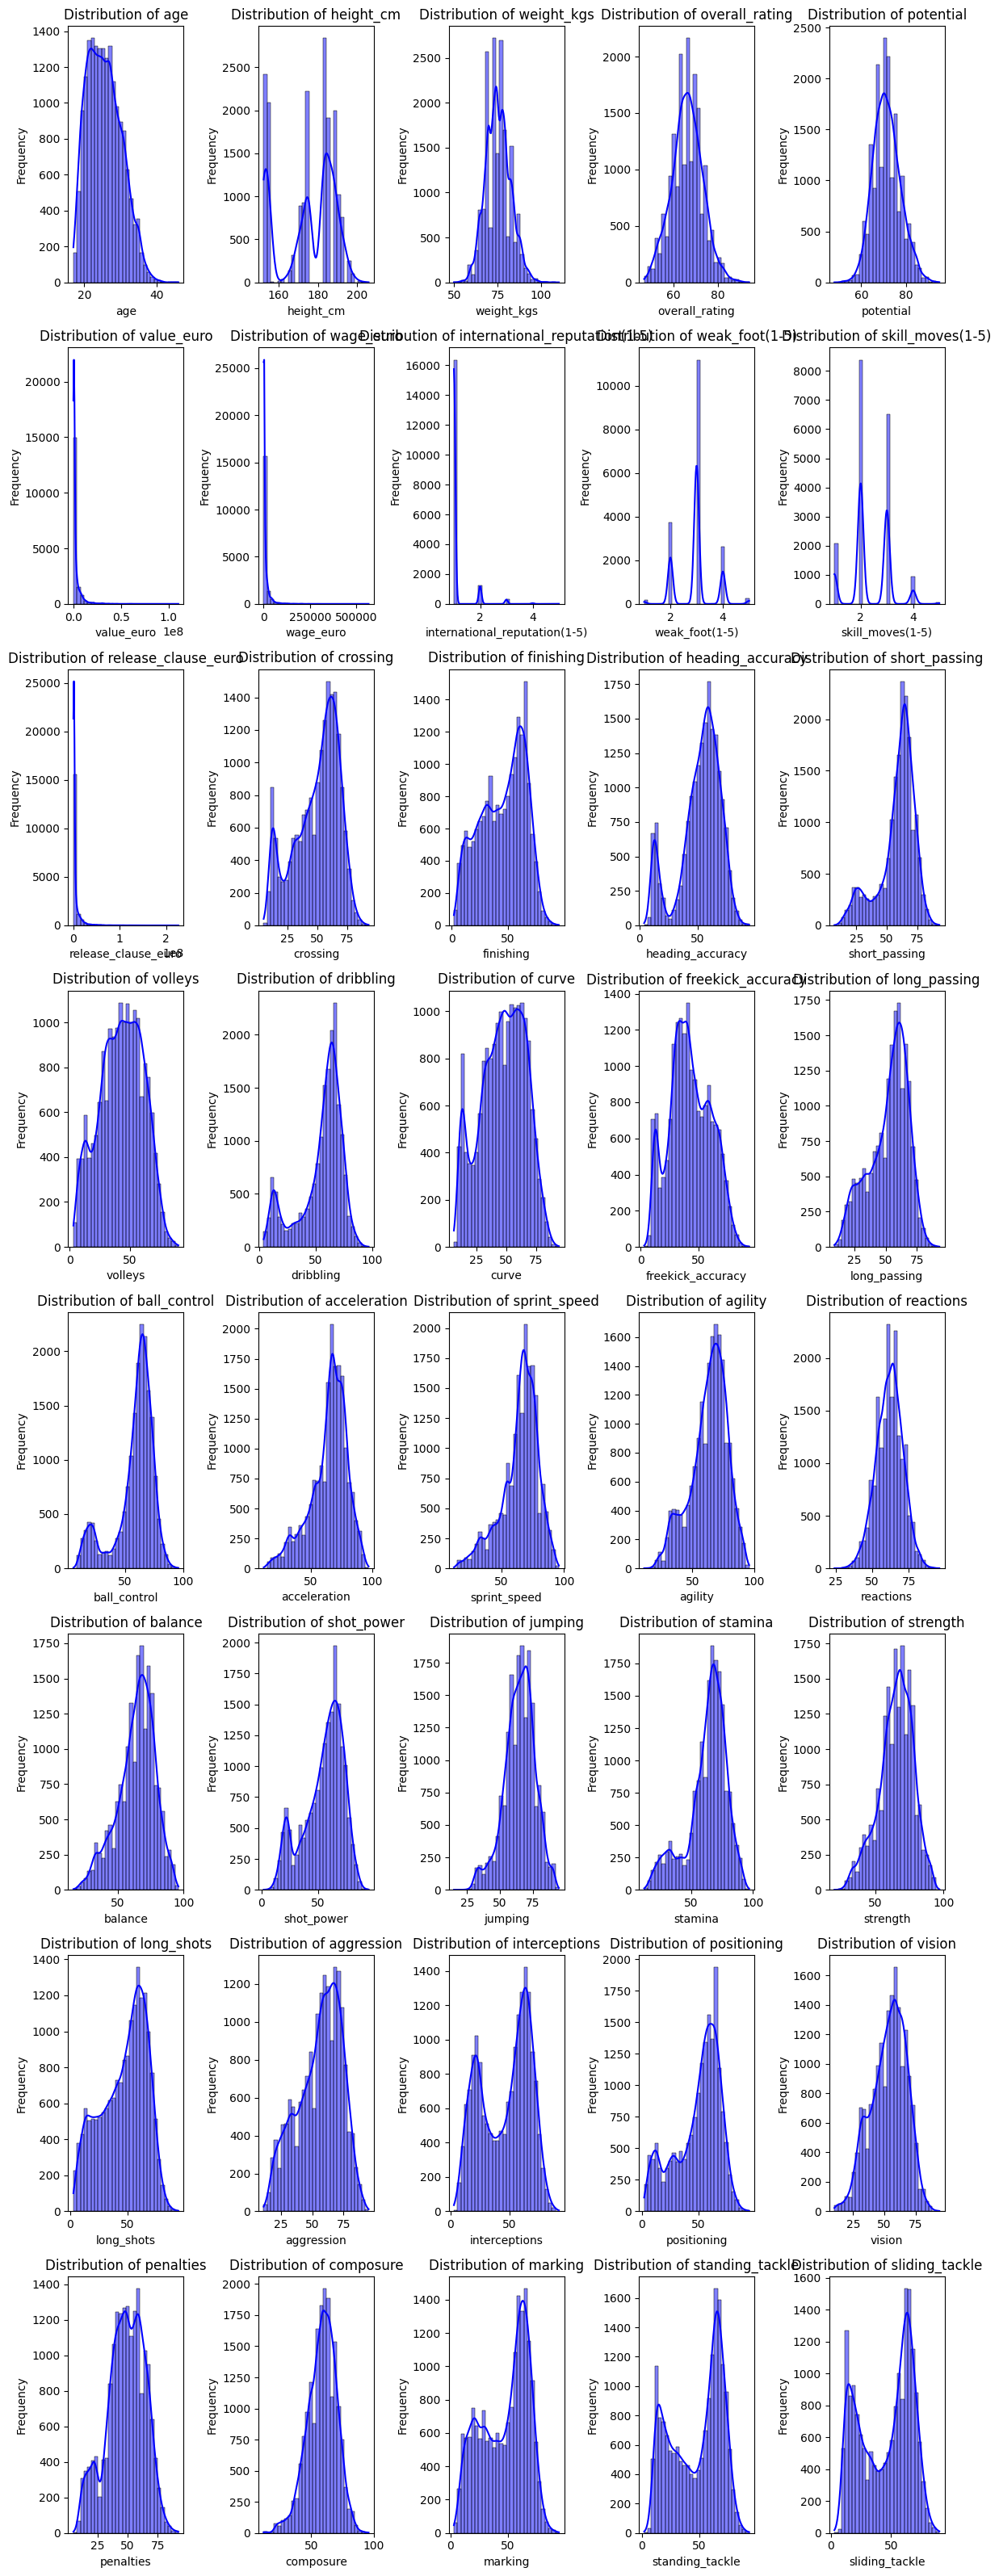

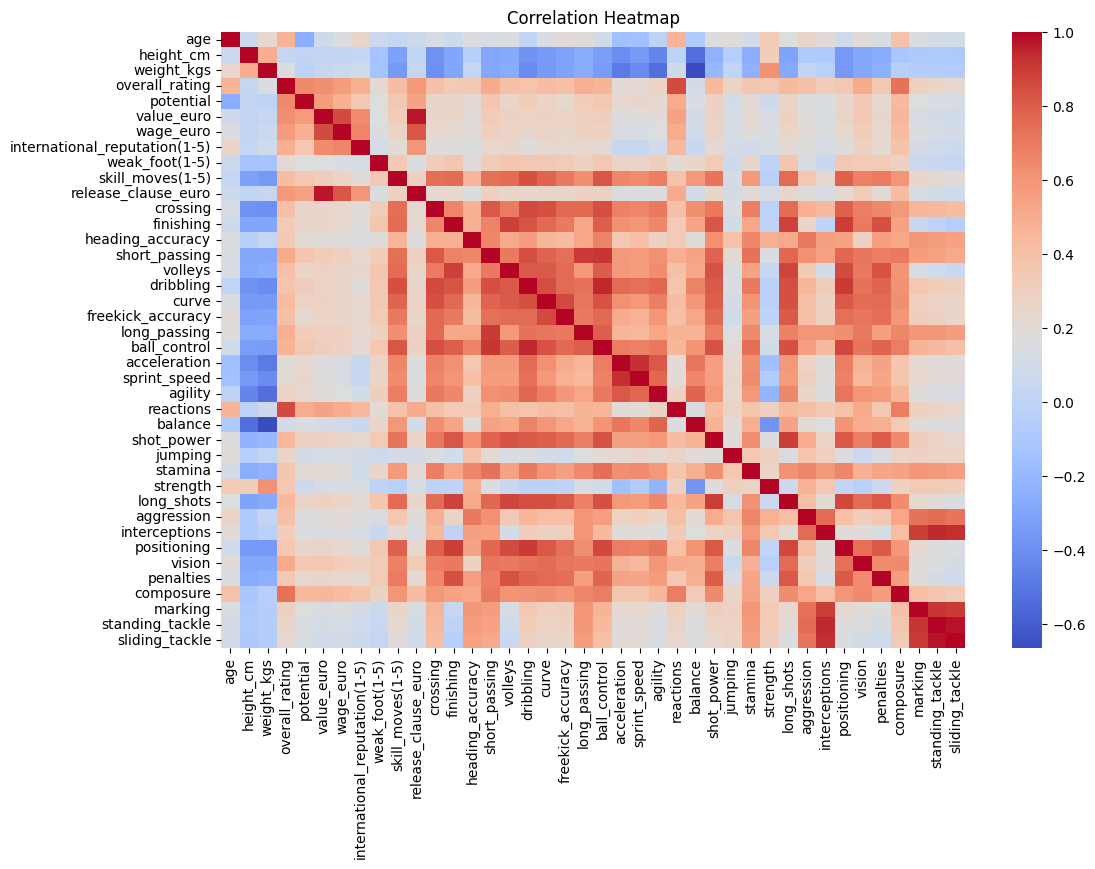

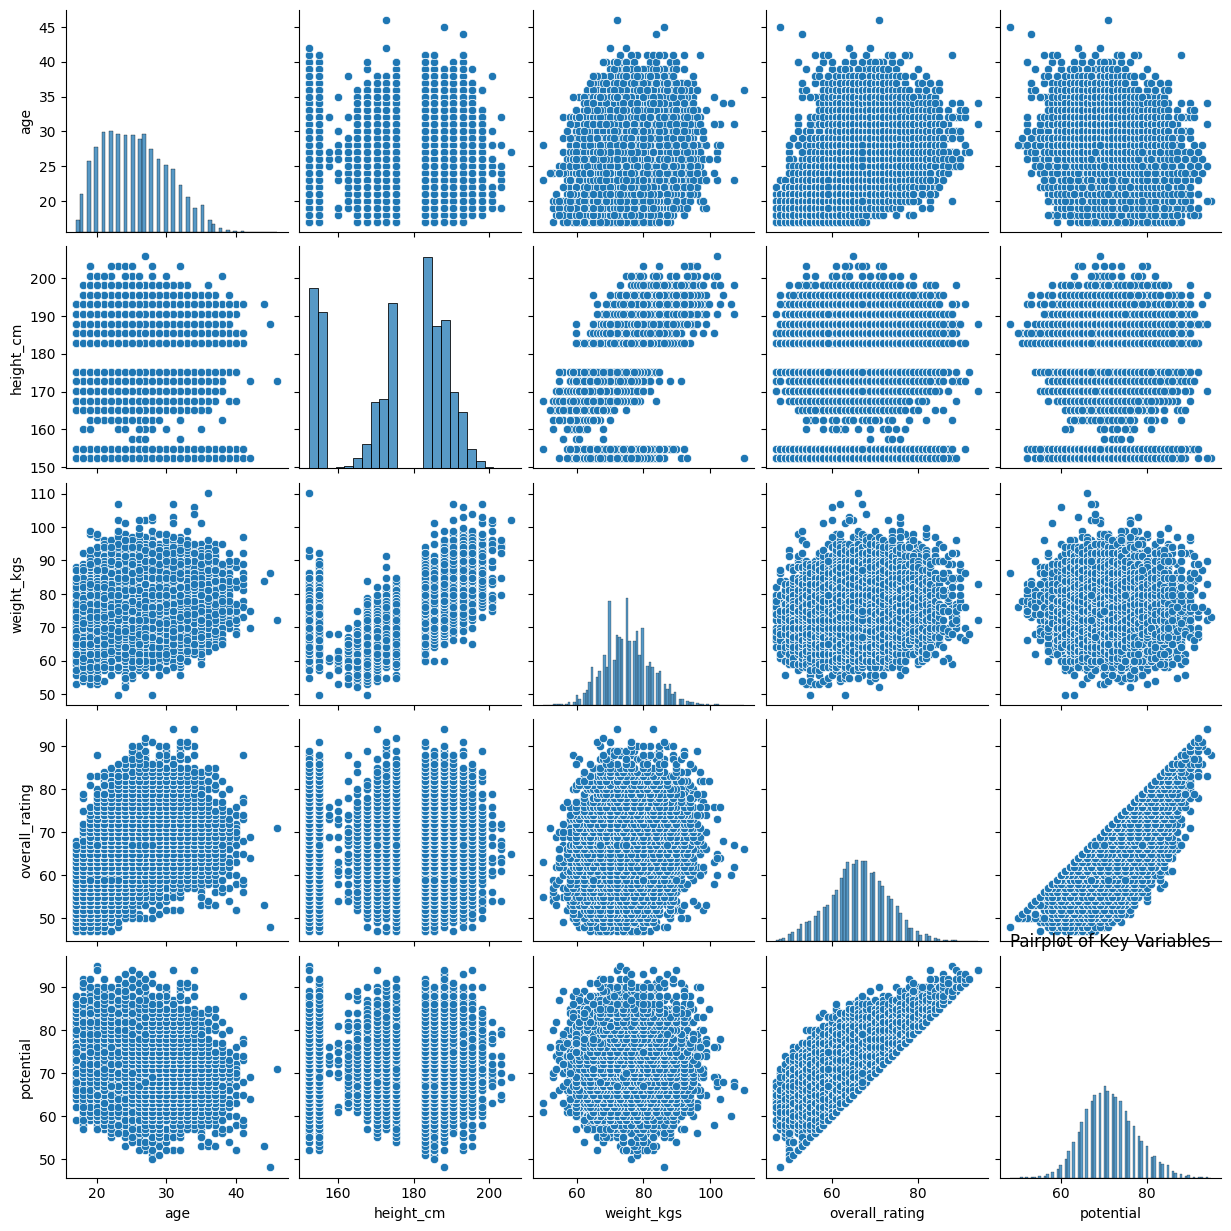

In [85]:
exploratory_data_analysis(cleaned_data)

# Step 6: Feature Transformation and Scaling

In [104]:
def feature_transformation(data, target_column=None):
    """
    Apply feature transformations including scaling, correlation filtering,
    and class weight balancing.
    """
    # Identify numeric features
    numeric_features = data.select_dtypes(include=['float64', 'int64']).columns

    # Scale numeric features
    scaler = StandardScaler()
    data[numeric_features] = scaler.fit_transform(data[numeric_features])
    display("\n--- Numeric Features Scaled ---")
    display(data[numeric_features].head())

    # Remove highly correlated features (correlation > 0.9)
    corr_matrix = data[numeric_features].corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
    data = data.drop(columns=to_drop)
    display(f"Dropped highly correlated features: {to_drop}")
    display("\n--- Correlation Matrix After Feature Dropping ---")
    display(corr_matrix.drop(columns=to_drop, index=to_drop))

  # Handle class imbalance 
    if target_column is not None and target_column in data.columns:
        if data[target_column].dtype == 'object' or len(data[target_column].unique()) < 2000:
            class_weights = compute_class_weight(
                class_weight='balanced',
                classes=np.unique(data[target_column]),
                y=data[target_column]
            )
            class_weights_dict = dict(zip(np.unique(data[target_column]), class_weights))
            print("\n--- Computed Class Weights ---")
            display(class_weights_dict)
        else:
            print(f"Target column '{target_column}' is not categorical or has too many unique values.")
    else:
        print(f"Target column '{target_column}' not found in the dataset.")
        
    return data

## Perform feature transformation

In [105]:
target_column = 'value_euro'
transformed_data = feature_transformation(cleaned_data, target_column)

'\n--- Numeric Features Scaled ---'

,age,height_cm,weight_kgs,overall_rating,potential,value_euro,wage_euro,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,1.154918,-0.339789,-0.451903,3.986456,3.681038,19.122347,25.399384,9.915228,1.588592,2.147489,...,2.426684,-0.449392,-1.188102,2.241456,2.867672,1.685137,3.210247,-0.706843,-0.910432,-0.925803
1,0.304863,-1.426106,0.126908,3.124825,2.865533,11.866027,8.929818,4.815230,3.095358,2.147489,...,2.169334,-0.564377,0.450131,1.733681,2.655742,1.179141,2.522088,0.590770,0.427554,-1.113727
2,-0.120165,1.108633,1.213944,3.124825,3.191735,12.485469,11.217258,7.365229,1.588592,3.457759,...,1.809044,1.275384,0.835597,1.632126,2.443813,2.127884,2.436068,0.790403,0.888928,1.000417
3,0.304863,-0.882947,-2.301275,3.124825,2.702432,10.538652,7.099867,4.815230,1.588592,2.147489,...,1.911984,-1.254288,-0.995369,1.682903,2.373169,0.799644,2.091988,0.191505,-1.094982,-1.113727
4,0.304863,0.927580,1.919811,3.124825,3.191735,10.184685,5.727403,4.815230,0.081826,-0.473052,...,-1.639446,1.792817,1.991997,-1.312969,-0.311272,-0.971342,1.833928,2.187833,1.857815,1.940036


"Dropped highly correlated features: ['release_clause_euro', 'ball_control', 'sprint_speed', 'positioning', 'standing_tackle', 'sliding_tackle']"

'\n--- Correlation Matrix After Feature Dropping ---'

,age,height_cm,weight_kgs,overall_rating,potential,value_euro,wage_euro,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),...,jumping,stamina,strength,long_shots,aggression,interceptions,vision,penalties,composure,marking
age,1.000000,0.059579,0.233819,0.461529,0.259579,0.079459,0.149848,0.259977,0.061108,0.029681,...,0.183816,0.103804,0.339671,0.164655,0.264859,0.198131,0.193201,0.147924,0.394717,0.146725
height_cm,0.059579,1.000000,0.495320,0.038080,0.008526,0.010695,0.020758,0.026850,0.130464,0.320141,...,0.052169,0.254794,0.318769,0.305601,0.073996,0.078730,0.287254,0.272134,0.111849,0.089783
weight_kgs,0.233819,0.495320,1.000000,0.150521,0.015099,0.043712,0.061236,0.085086,0.128875,0.353601,...,0.005741,0.232554,0.610431,0.278552,0.021926,0.034607,0.282234,0.251453,0.044538,0.057559
overall_rating,0.461529,0.038080,0.150521,1.000000,0.647249,0.626326,0.573311,0.489416,0.216394,0.418718,...,0.271008,0.368749,0.360725,0.429458,0.397072,0.322030,0.506812,0.350902,0.729278,0.292538
potential,0.259579,0.008526,0.015099,0.647249,1.000000,0.573091,0.481842,0.358874,0.167735,0.356241,...,0.106849,0.199151,0.077918,0.265326,0.170005,0.151946,0.348179,0.226746,0.434113,0.162999
value_euro,0.079459,0.010695,0.043712,0.626326,0.573091,1.000000,0.856652,0.641245,0.166382,0.315348,...,0.128491,0.214725,0.137417,0.281857,0.187722,0.141303,0.360471,0.241110,0.452395,0.136704
wage_euro,0.149848,0.020758,0.061236,0.573311,0.481842,0.856652,1.000000,0.665894,0.144874,0.267823,...,0.134560,0.183826,0.146678,0.255134,0.199222,0.158936,0.323031,0.228394,0.424920,0.149495
international_reputation(1-5),0.259977,0.026850,0.085086,0.489416,0.358874,0.641245,0.665894,1.000000,0.126238,0.205661,...,0.122657,0.092467,0.133690,0.214299,0.172931,0.126500,0.283890,0.220608,0.388906,0.115318
weak_foot(1-5),0.061108,0.130464,0.128875,0.216394,0.167735,0.166382,0.144874,0.126238,1.000000,0.345284,...,0.071491,0.241490,0.003609,0.365599,0.137035,0.056744,0.343684,0.337573,0.285560,0.067002
skill_moves(1-5),0.029681,0.320141,0.353601,0.418718,0.356241,0.315348,0.267823,0.205661,0.345284,1.000000,...,0.109956,0.582970,0.033415,0.757054,0.360342,0.221912,0.676089,0.695889,0.598595,0.255601



--- Computed Class Weights ---


{-0.4325490406908737: 6.545388261028071,
 -0.43077920671360675: 4.254502369668247,
 -0.4290093727363398: 3.8677294269711333,
 -0.4272395387590729: 1.289243142323711,
 -0.4254697047818059: 0.6807203791469194,
 -0.42369987080453897: 0.5828085437901708,
 -0.42193003682727204: 0.6165945463287313,
 -0.4201602028500051: 0.7335348913221115,
 -0.4183903688727381: 0.5710741435796304,
 -0.4166205348954712: 0.5419748241615601,
 -0.41485070091820425: 0.4701107590793642,
 -0.4130808669409373: 0.43192917458560875,
 -0.4113110329636704: 0.4550269914083686,
 -0.4095411989864034: 0.43635921740187145,
 -0.40777136500913647: 0.48902326088140763,
 -0.40600153103186953: 0.47536339325902194,
 -0.4042316970546026: 0.5285096111389126,
 -0.4024618630773356: 0.3867729426971133,
 -0.4006920291000687: 0.5385446037554742,
 -0.39892219512280175: 0.49470957786840075,
 -0.3971523611455348: 0.5385446037554742,
 -0.3953825271682678: 0.5598029433774009,
 -0.3936126931910009: 0.6397747924313153,
 -0.39184285921373396: 0.

# Step 7: Predictions of four regression methods

## Data preparation

In [ ]:
filtered_data = data[data['value_euro'] > 2000000]

X = filtered_data.drop(columns=['value_euro'])
y = filtered_data['value_euro']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mask = ~y_train.isna()
X_train = X_train[mask]
y_train = y_train[mask]

numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

## List of models and hyperparameters

In [123]:
models_and_params = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10, 100]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10, 100]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [5, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__gamma': ['scale', 'auto'],
            'model__kernel': ['linear', 'rbf']
        }
    }
}

## Hyperparameter selection using GridSearchCV

In [ ]:
best_models = {}
results = []

for name, mp in models_and_params.items():
    print(f"\n=== Training {name} ===")
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mp['model'])
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=mp['params'],
        scoring='r2', 
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()

    best_models[name] = grid_search.best_estimator_
    y_pred = best_models[name].predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    training_time = end_time - start_time
    
    results.append({
        'model_name': name,
        'mse': mse,
        'r2': r2,
        'training_time': training_time
    })


results_df = pd.DataFrame(results)
print(results_df)



=== Training LinearRegression ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits

=== Training Ridge ===
Fitting 5 folds for each of 5 candidates, totalling 25 fits

=== Training Lasso ===
Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291645993024248.8, tolerance: 32810765575487.465
  model = cd_fast.sparse_enet_coordinate_descent(



=== Training RandomForest ===
Fitting 5 folds for each of 27 candidates, totalling 135 fits

=== Training SVR ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
         model_name           mse        r2  training_time
0  LinearRegression  2.612982e+12  0.958916       0.689049
1             Ridge  2.350120e+12  0.963049       1.844391
2             Lasso  2.459863e+12  0.961324     130.370381
3      RandomForest  1.031001e+12  0.983790     650.445232
4               SVR  6.604054e+13 -0.038345      34.111509


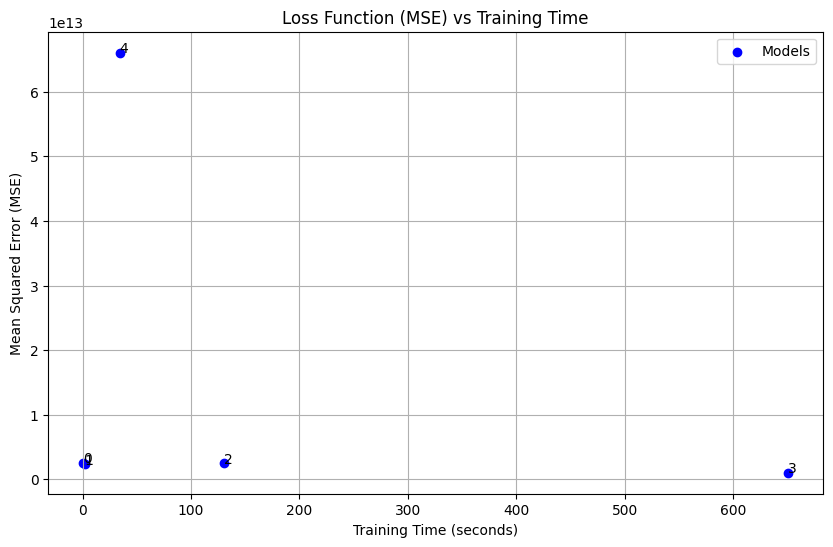

In [132]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['training_time'], results_df['mse'], color='blue', label='Models')
for i, txt in enumerate(results_df.index):
    plt.annotate(txt, (results_df['training_time'][i], results_df['mse'][i]))
    
plt.title('Loss Function (MSE) vs Training Time')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.legend()
plt.show()

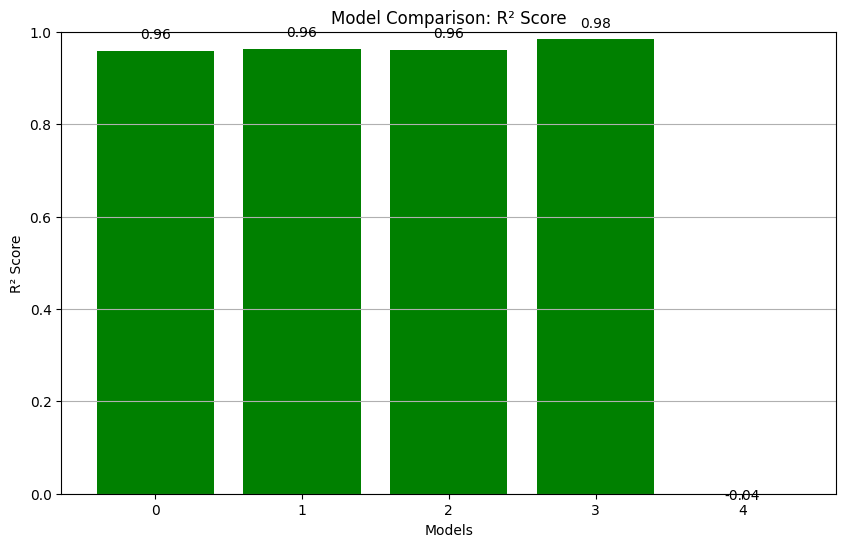

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['r2'], color='green')
plt.title('Model Comparison: R² Score')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.grid(axis='y')

for index, value in enumerate(results_df['r2']):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

plt.show()